<a href="https://colab.research.google.com/github/Janith123gihan/Car-Damage-Classification/blob/main/Car_Damage_Classification_Transfer_Learning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras import layers
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from keras.utils import plot_model
from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

In [ ]:

print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.11.0
Found GPU at: /device:GPU:0


In [ ]:
def set_data(train,test, validation ,batchSize, image_size):
 
 Image_size = [image_size,image_size]
#  we have to crop the image thatswhy we are using image size

 train_datagen= ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,rescale=1./255,
                                   zoom_range=0.2,
                                   horizontal_flip=0.5, vertical_flip=0.5
                                   )
#  using image data generator we can perform data aughmentation

 test_datagen = ImageDataGenerator(rescale=1./255) #using image datagenerator we can normalize test images by dividing 255

 val_datagen = ImageDataGenerator(rescale=1./255) #using image datagenerator we can normalize validation images by dividing 255

 #Training dataset
 train_set = train_datagen.flow_from_directory(
                train,
                target_size=Image_size,
                batch_size=batchSize, 
                color_mode='rgb',
                interpolation='bicubic',
                #shuffle=True,             
                class_mode='categorical'
                )
#  in here training data are normalized and aughmentation is performed here
 #Testing dataset
 test_set= test_datagen.flow_from_directory(
              test,
              target_size=Image_size,
              color_mode = 'rgb',interpolation='bicubic',  #Using interpolation='bicubic' in ImageDataGenerator can help improve the quality of the images that are fed into your deep learning model, which can lead to better model performance. 
              class_mode='categorical', shuffle=False
             )
 validation_set = val_datagen.flow_from_directory(
    validation, # same directory as training data
    target_size=Image_size,
    color_mode = 'rgb',interpolation='bicubic',
    batch_size=batchSize)
 return train_set, test_set, validation_set;

In [ ]:
def unfreeze_model(model, num_of_layers):
    for layer in model.layers[num_of_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    return model

    # in here layers are unfreezed which means we can manually train some layers in our model after unfreezing layers.

# Model Creation with vgg16

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

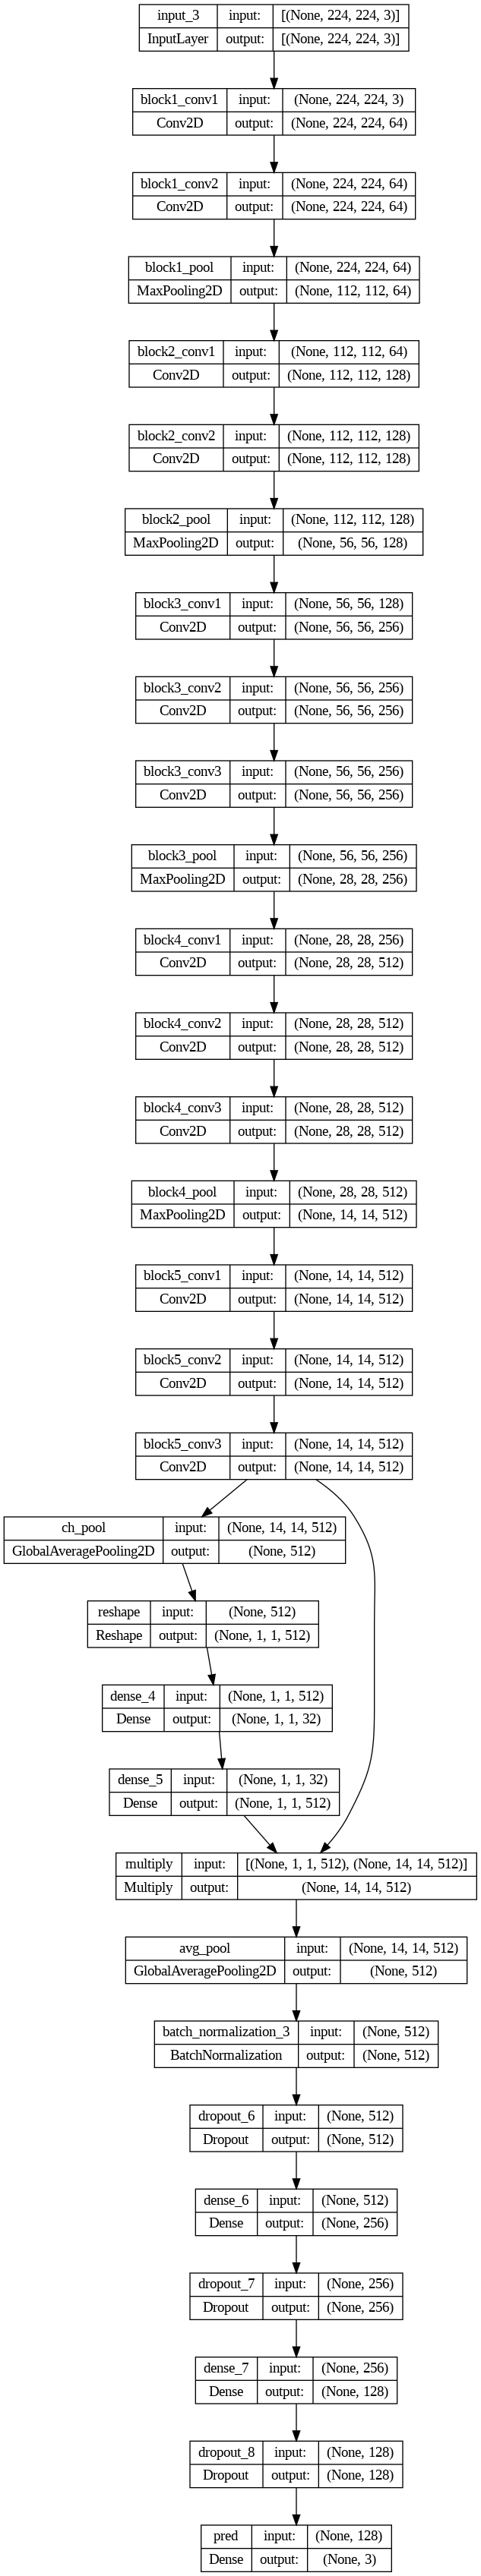

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape = (224,224,3)))  #classification part is removed thatswhy include_top become false
# base model is created with vgg16 algorithm with size 224x224

head_model = Model(base_model.input, base_model.layers[-2].output) #last two layers are removed because that layers have some layers that are triained for some set of classes in our case we have three classes so we have to modify/add new for it.
head_model.trainable = False #head model is not allowed to train head layers are frozen
head_model = unfreeze_model(head_model,-4)  #last three layers are unfreezed (we can train last three layers of vgg 16 also)

x = head_model.output
# output of the headmodel

se = layers.GlobalAveragePooling2D(name="ch_pool")(x) #global average pooling2d do technique like flatten but that will reduce parameters.
se = layers.Reshape((1,1,512))(se) #layers are reshaped in here input is (None,512) it is reshaped to (1,1,512)
se = layers.Dense(32,activation="swish",kernel_initializer='he_normal', use_bias=False)(se)  #32 dense layers are added with actication function swish 
se = layers.Dense(512,activation="sigmoid",kernel_initializer='he_normal', use_bias=False)(se) #512 dense layers are added with actication function swish 
x = layers.Multiply()([se, x])  #in here this is called channel attention se was multiplied with x 


# The purpose of channel attention is to help the network focus on the most relevant features and ignore the irrelevant ones. 
# It does this by learning a set of weights that are applied to the feature maps to adjust their importance.

x = layers.GlobalAveragePooling2D(name="avg_pool")(x) #global average pooling is added 
x = layers.BatchNormalization()(x) #it will normalize values to one - zero it will help to increase model accuracy.
x = layers.Dropout(0.4)(x) #dropout layer is added.
x = layers.Dense(256, activation="relu",kernel_initializer="orthogonal")(x)  #256 dense layers are added followed by activation funtion relu

x = layers.Dropout(0.6)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)


outputs = layers.Dense(3, activation="softmax", name="pred")(x) #in here three softmax layers are added becuase we have three classes 
model = tf.keras.Model(head_model.input, outputs) #model type is created
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #optimiser is added with learning rate 0.0001
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"]) #categorical crossentropy is used as loss function and categorical accuracy is use for metrics
model.summary()
plot_model(model,show_shapes=True, show_layer_names=True) #plot model function is used to display model architecture







In [ ]:
def plot_hist(hist): #this is a function for plot model accuracy in training time this function will return histogram 
    plt.figure(3)
    plt.plot(hist.history["categorical_accuracy"]) 
    plt.plot(hist.history["val_categorical_accuracy"])

    # categorical accuracy and validation categorical accuracy are plotted in the same graph with title model accuracy and ylabel = accuracy xlabel = epoch
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
    plt.figure(4)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    # in the same graph loss and val_loss are displayed and title is model loss
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Found 784 images belonging to 3 classes.
Found 195 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/80
25/25 [==============================] - ETA: 0s - loss: 1.2246 - categorical_accuracy: 0.3878
Epoch 1: val_categorical_accuracy improved from -inf to 0.39766, saving model to /content/drive/MyDrive/Car Damage Classification/vgg16/checkpoint.hdf5
25/25 [==============================] - 19s 611ms/step - loss: 1.2246 - categorical_accuracy: 0.3878 - val_loss: 1.0742 - val_categorical_accuracy: 0.3977
Epoch 2/80
25/25 [==============================] - ETA: 0s - loss: 1.0216 - categorical_accuracy: 0.4923
Epoch 2: val_categorical_accuracy improved from 0.39766 to 0.40351, saving model to /content/drive/MyDrive/Car Damage Classification/vgg16/checkpoint.hdf5
25/25 [==============================] - 14s 549ms/step - loss: 1.0216 - categorical_accuracy: 0.4923 - val_loss: 1.0475 - val_categorical_accuracy: 0.4035
Epoch 3/80
25/25 [============================

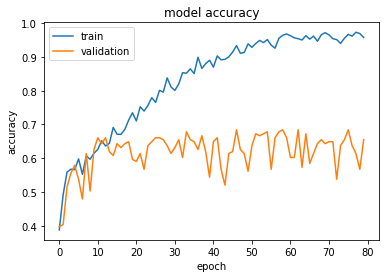

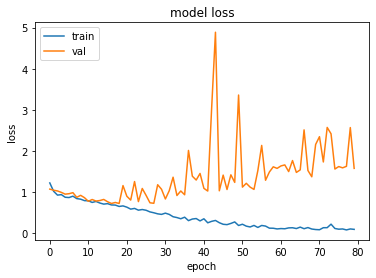

In [ ]:
batchSize = 32 #32 batches are used in each epoch 
epoches =80;
image_size = 224;
train_path = '/content/drive/MyDrive/Car Damage Classification/training'
test_path = '/content/drive/MyDrive/Car Damage Classification/testing'
validation_path = '/content/drive/MyDrive/Car Damage Classification/validation'

checkpoint_path = "/content/drive/MyDrive/Car Damage Classification/vgg16/checkpoint.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  monitor='val_categorical_accuracy',mode='max',
                                                save_best_only=True,
                                                verbose=1)



train_set, test_set, validation_set = set_data(train_path,test_path,validation_path, batchSize, image_size)

history=model.fit(train_set,  validation_data= validation_set,epochs = epoches,callbacks=[cp_callback], shuffle=True)
plot_hist(history)


In [ ]:
model.save('/content/drive/MyDrive/Car Damage Classification/vgg16/h5 files/vgg16 fully connected/2/model5.h5')

# Testing Model

In [ ]:

model.save('/content/drive/MyDrive/Car Damage Classification/my_model')
results = model.evaluate(test_set,batch_size=32)
accuracy = results[1]
predict_labels=model.predict(test_set,batch_size=batchSize)
test_labels=test_set.classes
print(accuracy)


7/7 [==============================] - 1s 135ms/step
0.7435897588729858


In [ ]:
print(test_labels)
print(predict_labels.argmax(axis=1))
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_labels, predict_labels.argmax(axis=1), target_names=['minor', 'moderate', 'severe']))
confusion = confusion_matrix(test_labels, predict_labels.argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)
